In [52]:
import os
import pandas as pd
import numpy as np
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [53]:
data = pd.read_sql("select * from sports_data.tourney_games_through_2024_final", conn)

In [54]:
# later games in the tournament should be weighted higher so lets duplicate those
data['date_dt'] = data['date'].apply(lambda x: pd.to_datetime(x))

In [55]:
yearly_tournament_start_dates = data.groupby('season', as_index=False)['date_dt'].min()

In [56]:
yearly_tournament_start_dates['season']

0     2008
1     2009
2     2010
3     2011
4     2012
5     2013
6     2014
7     2015
8     2016
9     2017
10    2018
11    2019
12    2021
13    2022
14    2023
15    2024
Name: season, dtype: int64

In [57]:
def get_importance_factor(date):
    start_date = yearly_tournament_start_dates[yearly_tournament_start_dates['season'] == date.year]['date_dt'].values[0]
    return 1 + (date - start_date).days
data['importance_factor'] = data['date_dt'].apply(get_importance_factor)

In [58]:
importance_factor_duplicated_data = pd.DataFrame(columns=data.columns)
for i, row in data.iterrows():
    if i % 100 == 0:
        print(i)
    row_data = pd.DataFrame([row] * row['importance_factor'])
    importance_factor_duplicated_data = pd.concat([importance_factor_duplicated_data, row_data])
    

importance_factor_duplicated_data.reset_index(drop=True, inplace=True)

0
100


C:\Users\amarl\AppData\Local\Temp\ipykernel_20492\3873046170.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  importance_factor_duplicated_data = pd.concat([importance_factor_duplicated_data, row_data])


200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [59]:
importance_factor_duplicated_data = importance_factor_duplicated_data.replace(np.NaN, 0)
importance_factor_duplicated_data.drop(['date_dt', 'importance_factor'], axis=1, inplace=True)

In [60]:
importance_factor_duplicated_data['Win_Loss_Flag'] = importance_factor_duplicated_data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [61]:
importance_factor_duplicated_data.columns

Index(['date', 'season', 'team', 'opponent', 'Win_Loss',
       'regular_season_win_pct', 'opponent_regular_season_win_pct',
       'season_win_pct', 'opponent_season_win_pct', 'season_ppg',
       ...
       'opponent_season_allowed_free_throw_rate_std',
       'vs_tourney_team_allowed_free_throw_rate',
       'opponent_vs_tourney_team_allowed_free_throw_rate',
       'vs_tourney_team_allowed_free_throw_rate_std',
       'opponent_vs_tourney_team_allowed_free_throw_rate_std',
       'last_10_allowed_free_throw_rate',
       'opponent_last_10_allowed_free_throw_rate',
       'last_10_allowed_free_throw_rate_std',
       'opponent_last_10_allowed_free_throw_rate_std', 'Win_Loss_Flag'],
      dtype='object', length=177)

In [62]:
predictor_cols = importance_factor_duplicated_data.columns.to_list()

In [63]:
predictor_cols.remove('Win_Loss')
predictor_cols.remove('Win_Loss_Flag')
# 'date', 'season', 'team', 'opponent'
predictor_cols.remove('date')
predictor_cols.remove('season')
predictor_cols.remove('team')
predictor_cols.remove('opponent')

In [64]:
predictors = importance_factor_duplicated_data[predictor_cols]
predictors_and_response = pd.concat([predictors, importance_factor_duplicated_data['Win_Loss_Flag']], axis=1)

In [65]:
prediction_data = importance_factor_duplicated_data[predictor_cols]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [66]:
importance_factor_duplicated_data['Win_Loss_Flag']

0        0
1        1
2        1
3        1
4        0
        ..
15331    0
15332    0
15333    0
15334    0
15335    0
Name: Win_Loss_Flag, Length: 15336, dtype: int64

In [75]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=10000).fit(prediction_data_normalized, importance_factor_duplicated_data['Win_Loss_Flag'])

In [76]:
linreg_no_val_predictions = clf.predict(prediction_data_normalized)

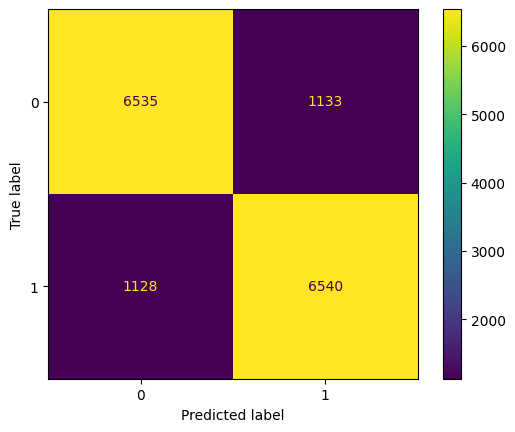

In [77]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(importance_factor_duplicated_data['Win_Loss_Flag'], linreg_no_val_predictions)).plot()

In [78]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [79]:
cms = proper_cross_validation(LogisticRegression(random_state=0, max_iter=10000), prediction_data_normalized, importance_factor_duplicated_data['Win_Loss_Flag'])

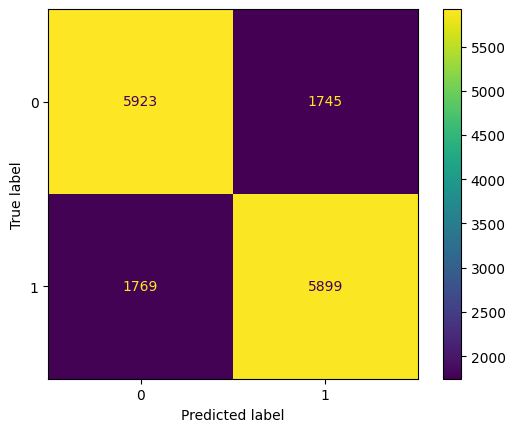

In [80]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [81]:
cms

array([[5923, 1745],
       [1769, 5899]], dtype=int64)

In [82]:
def expected_games_right(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    print(f"accuracy: {accuracy}")
    gr = 32.0 * accuracy
    gr = gr + (16 * (accuracy ** 2))
    gr = gr + (8 * (accuracy ** 3))
    gr = gr + (4 * (accuracy ** 4))
    gr = gr + (2 * (accuracy ** 5))
    gr = gr + (1 * (accuracy ** 6))
    return gr

In [83]:
def expected_score(confusion_matrix):
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / confusion_matrix.sum()
    gr = 32.0 * accuracy
    gr = gr + (32 * (accuracy ** 2))
    gr = gr + (32 * (accuracy ** 3))
    gr = gr + (32 * (accuracy ** 4))
    gr = gr + (32 * (accuracy ** 5))
    gr = gr + (32 * (accuracy ** 6))
    return gr

In [84]:
expected_games_right(cms)

accuracy: 0.7708659363588941


40.00675639458484

In [85]:
expected_score(cms)

85.06643631576009

accuracy: 0.7756911841418883
expected games correct: 40.41076918290616
expected score: 86.55443886740565


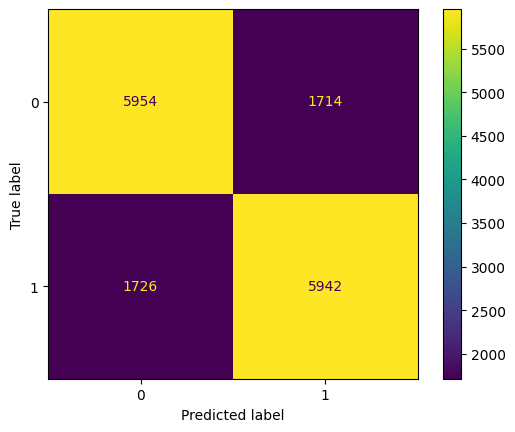

In [91]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
pca = PCA(n_components=158)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), importance_factor_duplicated_data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()
print(f"expected games correct: {expected_games_right(cms)}")
print(f"expected score: {expected_score(cms)}")

In [89]:
results_df = pd.DataFrame(columns=["n_components", "expected_games_right", "expected_score"])
for i in range(1, 172):
    pca = PCA(n_components=i)
    pca.fit(prediction_data_normalized)
    cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), importance_factor_duplicated_data['Win_Loss_Flag'])
    results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])

accuracy: 0.49947835159102766
accuracy: 0.5100417318727178


C:\Users\amarl\AppData\Local\Temp\ipykernel_20492\3768782804.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({"n_components": [i], "expected_games_right": [expected_games_right(cms)], "expected_score": [expected_score(cms)]})])


accuracy: 0.6264997391757955
accuracy: 0.662623891497131
accuracy: 0.6759259259259259
accuracy: 0.6752738654147105
accuracy: 0.6733828899321858
accuracy: 0.6754694835680751
accuracy: 0.6854460093896714
accuracy: 0.685641627543036
accuracy: 0.7013562858633281
accuracy: 0.7055946791862285
accuracy: 0.7059859154929577
accuracy: 0.7175273865414711
accuracy: 0.7160928534167971
accuracy: 0.7166145018257695
accuracy: 0.7150495565988524
accuracy: 0.718961919666145
accuracy: 0.719548774126239
accuracy: 0.7236567553468962
accuracy: 0.724960876369327
accuracy: 0.7325899843505478
accuracy: 0.731546687532603
accuracy: 0.730829420970266
accuracy: 0.7291340636411059
accuracy: 0.7271778821074596
accuracy: 0.7255477308294209
accuracy: 0.7242436098069901
accuracy: 0.7206572769953051
accuracy: 0.7243740219092332
accuracy: 0.7206572769953051
accuracy: 0.7153755868544601
accuracy: 0.7207224830464267
accuracy: 0.7224178403755869
accuracy: 0.7213093375065206
accuracy: 0.7174621804903495
accuracy: 0.717201356

In [90]:
results_df.tail(30)

,n_components,expected_games_right,expected_score
0,142,38.924149,81.149530
0,143,38.822916,80.788509
0,144,39.578694,83.505438
0,145,39.443924,83.017298
0,146,39.800436,84.312056
0,147,39.974128,84.946887
0,148,39.974128,84.946887
0,149,39.914359,84.728140
0,150,40.028519,85.146227
0,151,39.957821,84.887174


In [ ]:
new_data = pd.read_sql("select * from sports_data.tourney_games_2025_potential", conn)
new_data = new_data.replace(np.NaN, 0)

In [153]:
wk = new_data[new_data['team'].str.contains('Conn')]
a = wk[wk['opponent'].str.contains('Hou')].head()[['season_ppg', 'season_ppg_allowed','opponent_season_ppg', 'opponent_season_ppg_allowed']]


In [156]:
(a['season_ppg'] + a['opponent_season_ppg'] + a['season_ppg_allowed'] + a['opponent_season_ppg_allowed']) / 2

32    136.705882
dtype: float64

In [89]:
pca = PCA(n_components=171)
pca.fit(prediction_data_normalized)
# tol=0.000001, max_iter=30000, solver="liblinear"
cms = proper_cross_validation(LogisticRegression(max_iter=30000), pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])
clf = LogisticRegression(random_state=0).fit(pd.DataFrame(pca.transform(prediction_data_normalized)), data['Win_Loss_Flag'])

In [91]:
new_prediction_data = new_data[predictor_cols]
new_prediction_data_normalized = (new_prediction_data-prediction_data.mean())/prediction_data.std()
new_data_pca = pca.transform(new_prediction_data_normalized)

In [92]:
new_data['prediction'] = clf.predict(new_data_pca)
new_data['prediction_lose'] = [x[0] for x in clf.predict_proba(new_data_pca)]
new_data['prediction_win'] = [x[1] for x in clf.predict_proba(new_data_pca)]
preds = new_data[['season', 'team', 'opponent', 'prediction', 'prediction_lose', 'prediction_win']]

In [164]:
wk = preds[preds['team'].str.contains('Conn')]
wk[wk['opponent'].str.contains('Houston')]

,season,team,opponent,prediction,prediction_lose,prediction_win
32,2024,Connecticut,Houston,0,0.538391,0.461609
